<a href="https://colab.research.google.com/github/musman2012/imaging-research/blob/master/OpenCV/WorkingwithOCTImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#!pip install mat4py
import matplotlib.pyplot as plt
import numpy as np
import h5py
from mat4py import loadmat

data = loadmat('/content/2macula.mat')


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io

matfile = io.loadmat('/content/2macula.mat')


In [74]:
import cv2 as cv

def detect_edges(img):
  sobelx = cv.Sobel(img,cv.CV_32F,1,0,ksize=3)
  sobely = cv.Sobel(img,cv.CV_32F,0,1,ksize=3)
  gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
  return gradmag

def return_binary(img):
  #kernel = np.ones((9, 9), np.uint8)
  #gradient = cv.morphologyEx(img, cv.MORPH_GRADIENT, kernel)
  kernel1 = np.ones((5, 5), np.uint8)
  #dilation = cv.erode(gradient, kernel1, iterations=2)
  dilation = cv.erode(img, kernel1, iterations=1)
  #final = gradient-dilation
  edges = cv.Canny(dilation, 60, 60)
  #cv.imwrite("edges.png",edges)
  ret, binary = cv.threshold(edges, 15, 255, cv.THRESH_BINARY)
  return (ret, binary)

In [81]:
FILTER_INTENSITY = 25
img = cv.imread('/content/DH000.tif')
oneimage = cv.fastNlMeansDenoisingColored(img,None, FILTER_INTENSITY,10,7,21)
grad1 = detect_edges(img)
grad_denoise = detect_edges(oneimage)
cv.imwrite("magnitude_dn.png", grad_denoise)
cv.imwrite("magnitude.png", grad1)


True

In [82]:
(ret1, binary1) = return_binary(img)
(ret_dn, binary_dn) = return_binary(oneimage)
cv.imwrite("binary.png",binary1)
cv.imwrite("binary_dn.png",binary_dn)

True

In [83]:
img_an = cv.imread('/content/DH014.tif')
oneimage_an = cv.fastNlMeansDenoisingColored(img_an,None, FILTER_INTENSITY,10,7,21)
grad1_an = detect_edges(img_an)
grad_denoise_an = detect_edges(oneimage_an)
cv.imwrite("magnitude_dn_an.png", grad_denoise_an)
cv.imwrite("magnitude_an.png", grad1_an)

True

In [84]:
(ret1_an, binary1_an) = return_binary(img_an)
(ret_dn_an, binary_dn_an) = return_binary(oneimage_an)
cv.imwrite("binary_an.png",binary1_an)
cv.imwrite("binary_dn_an.png",binary_dn_an)

True

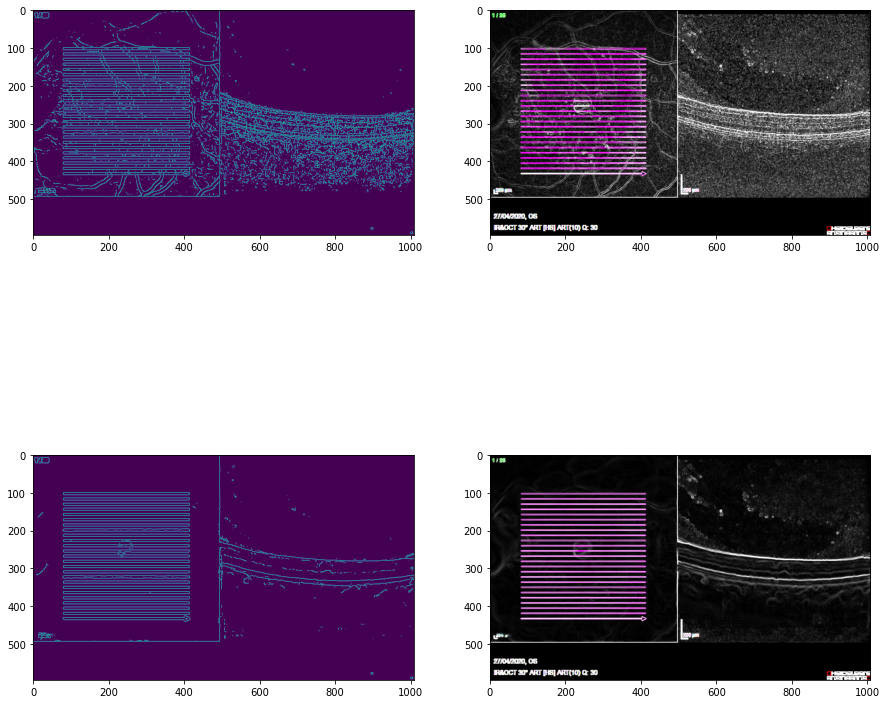

In [85]:
import matplotlib.image as mpimg

fig = plt.figure(figsize=(15, 15))
bin = mpimg.imread('/content/binary.png')
fig.add_subplot(2, 2, 1)
plt.imshow(bin)
mag = mpimg.imread('/content/magnitude.png')
fig.add_subplot(2, 2, 2)
plt.imshow(mag)
bin_dn = mpimg.imread('/content/binary_dn.png')
fig.add_subplot(2, 2, 3)
plt.imshow(bin_dn)
mag_dn = mpimg.imread('/content/magnitude_dn.png')
fig.add_subplot(2, 2, 4)
plt.imshow(mag_dn)
plt.show()


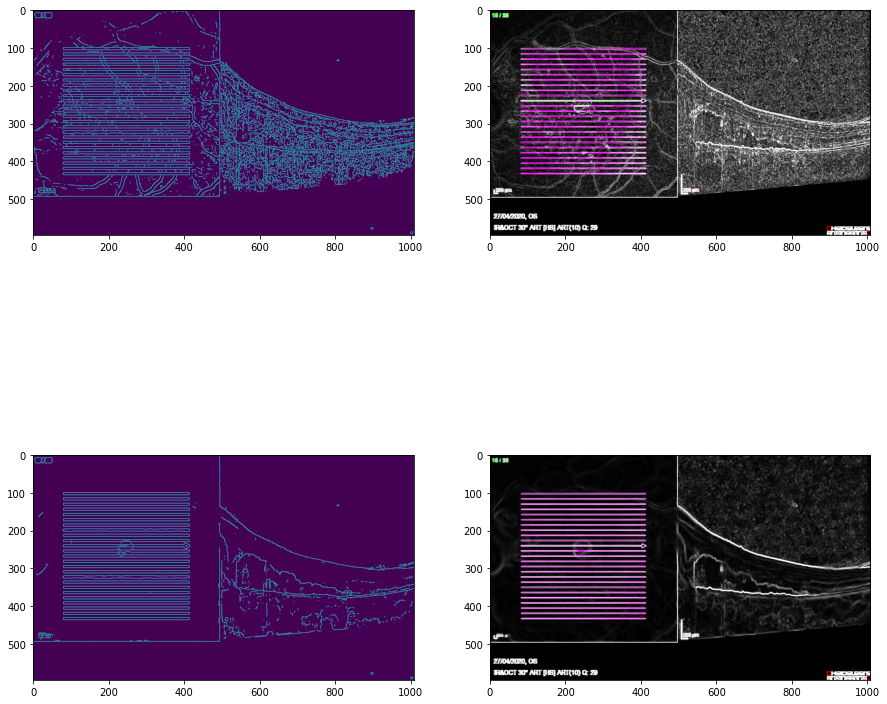

In [86]:
import matplotlib.image as mpimg

fig = plt.figure(figsize=(15, 15))
bin_an = mpimg.imread('/content/binary_an.png')
fig.add_subplot(2, 2, 1)
plt.imshow(bin_an)
mag_an = mpimg.imread('/content/magnitude_an.png')
fig.add_subplot(2, 2, 2)
plt.imshow(mag_an)
bin_dn_an = mpimg.imread('/content/binary_dn_an.png')
fig.add_subplot(2, 2, 3)
plt.imshow(bin_dn_an)
mag_dn_an = mpimg.imread('/content/magnitude_dn_an.png')
fig.add_subplot(2, 2, 4)
plt.imshow(mag_dn_an)
plt.show()